<a href="https://colab.research.google.com/github/vitutorial/exercises/blob/master/CharLM/CharLM-Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

import os
import re
import urllib.request
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import itertools

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In this notebook you will work with a generative language model that generates inflected wordforms one character at a time. We will use text data (we will work on the character level) in Spanish and pytorch. 

The first section concerns data manipulation and data loading classes necessary for our implementation. You do not need to modify anything in this part of the code.

Let's first download the SIGMORPHON dataset that we will be using for this notebook: these are inflected Spanish words together with some morphosyntactic descriptors. For this notebook we will ignore the morphosyntactic descriptors.

In [2]:
url = "https://raw.githubusercontent.com/ryancotterell/sigmorphon2016/master/data/"
train_file = "spanish-task1-train"
val_file = "spanish-task1-dev"
test_file = "spanish-task1-test"

print("Downloading data files...")
if not os.path.isfile(train_file):
    urllib.request.urlretrieve(url + train_file, filename=train_file)
if not os.path.isfile(val_file):
    urllib.request.urlretrieve(url + val_file, filename=val_file)
if not os.path.isfile(test_file):
    urllib.request.urlretrieve(url + test_file, filename=test_file)
print("Download complete.")

Download complete.


# Data

In order to work with text data, we need to transform the text into something that our algorithms can work with. The first step of this process is converting words into word ids. We do this by constructing a vocabulary from the data, assigning a new word id to each new word it encounters.

In [0]:
UNK_TOKEN = "?"
PAD_TOKEN = "_"
SOW_TOKEN = ">"
EOW_TOKEN = "."

def extract_inflected_word(s):
    """
    Extracts the inflected words in the SIGMORPHON dataset.
    """
    return s.split()[-1]

class Vocabulary:
    
    def __init__(self):
        self.idx_to_char = {0: UNK_TOKEN, 1: PAD_TOKEN, 2: SOW_TOKEN, 3: EOW_TOKEN}
        self.char_to_idx = {UNK_TOKEN: 0, PAD_TOKEN: 1, SOW_TOKEN: 2, EOW_TOKEN: 3}
        self.word_freqs = {}
    
    def __getitem__(self, key):
        return self.char_to_idx[key] if key in self.char_to_idx else self.char_to_idx[UNK_TOKEN]
    
    def word(self, idx):
        return self.idx_to_char[idx]
    
    def size(self):
        return len(self.char_to_idx)
    
    @staticmethod
    def from_data(filenames):
        """
            Creates a vocabulary from a list of data files. It assumes that the data files have been
            tokenized and pre-processed beforehand.
        """
        vocab = Vocabulary()
        for filename in filenames:
            with open(filename) as f:
                for line in f:
                    
                    # Strip whitespace and the newline symbol.
                    word = extract_inflected_word(line.strip())
                    
                    # Split the words into characters and assign ids to each
                    # new character it encounters.
                    for char in list(word):
                        if char not in vocab.char_to_idx:
                            idx = len(vocab.char_to_idx)
                            vocab.char_to_idx[char] = idx
                            vocab.idx_to_char[idx] = char
                            
        return vocab

In [4]:
# Construct a vocabulary from the training and validation data.
print("Constructing vocabulary...")
vocab = Vocabulary.from_data([train_file, val_file])
print("Constructed a vocabulary of %d types" % vocab.size())

Constructing vocabulary...
Constructed a vocabulary of 37 types


In [5]:
# some examples
print('e', vocab['e'])
print('é', vocab['é'])
print('ș', vocab['ș'])  # something UNKNOWN

e 8
é 24
ș 0


We also need to load the data files into memory. We create a simple class `TextDataset` that stores the data as a list of words:

In [0]:
class TextDataset(Dataset):
    """
        A simple class that loads a list of words into memory from a text file,
        split by newlines. This does not do any memory optimisation, 
        so if your dataset is very large, you might want to use an alternative 
        class.
    """
    
    def __init__(self, text_file, max_len=30):
        self.data = []
        with open(text_file) as f:
            for line in f:
                word = extract_inflected_word(line.strip())
                if len(list(word)) <= max_len:
                    self.data.append(word)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
# Load the training, validation, and test datasets into memory.
train_dataset = TextDataset(train_file)
val_dataset = TextDataset(val_file)
test_dataset = TextDataset(test_file)

# Print some samples from the data:
print("Sample from training data: \"%s\"" % train_dataset[np.random.choice(len(train_dataset))])
print("Sample from validation data: \"%s\"" % val_dataset[np.random.choice(len(val_dataset))])
print("Sample from test data: \"%s\"" % test_dataset[np.random.choice(len(test_dataset))])

Sample from training data: "espatos"
Sample from validation data: "asemejemos"
Sample from test data: "corrugue"


Now it's time to write a function that converts a word into a list of character ids using the vocabulary we created before. This function is `create_batch` in the code cell below. This function creates a batch from a list of words, and makes sure that each word starts with a start-of-word symbol and ends with an end-of-word symbol. Because not all words are of equal length in a certain batch, words are padded with padding symbols so that they match the length of the largest word in the batch. The function returns an input batch, an output batch, a mask of 1s for words and 0s for padding symbols, and the sequence lengths of each word in the batch. The output batch is shifted by one character, to reflect the predictions that the model is expected to make. For example, for a word
\begin{align}
    \text{e s p e s e m o s}
\end{align}
the input sequence is
\begin{align}
    \text{SOW e s p e s e m o s}
\end{align}
and the output sequence is
\begin{align}
    \text{e s p e s e m o s EOW}
\end{align}

You can see the output is shifted wrt the input, that's because we will be computing a distribution for the next character in context of its prefix, and that's why we need to shift the sequence this way.


Lastly, we create an inverse function `batch_to_words` that recovers the list of words from a padded batch of character ids to use during test time.

In [0]:
def create_batch(words, vocab, device, word_dropout=0.):
    """
    Converts a list of words to a padded batch of word ids. Returns
    an input batch, an output batch shifted by one, a sequence mask over
    the input batch, and a tensor containing the sequence length of each
    batch element.
    :param words: a list of words, each a list of token ids
    :param vocab: a Vocabulary object for this dataset
    :param device: 
    :param word_dropout: rate at which we omit words from the context (input)
    :returns: a batch of padded inputs, a batch of padded outputs, mask, lengths
    """
    tok = np.array([[SOW_TOKEN] + list(w) + [EOW_TOKEN] for w in words])
    seq_lengths = [len(w)-1 for w in tok]
    max_len = max(seq_lengths)
    pad_id = vocab[PAD_TOKEN]
    pad_id_input = [
        [vocab[w[t]] if t < seq_lengths[idx] else pad_id for t in range(max_len)]
            for idx, w in enumerate(tok)]
    
    # Replace words of the input with <unk> with p = word_dropout.
    if word_dropout > 0.:
        unk_id = vocab[UNK_TOKEN]
        word_drop =  [
            [unk_id if (np.random.random() < word_dropout and t < seq_lengths[idx]) else word_ids[t] for t in range(max_len)] 
                for idx, word_ids in enumerate(pad_id_input)]
    
    # The output batch is shifted by 1.
    pad_id_output = [
        [vocab[w[t+1]] if t < seq_lengths[idx] else pad_id for t in range(max_len)]
            for idx, w in enumerate(tok)]
    
    # Convert everything to PyTorch tensors.
    batch_input = torch.tensor(pad_id_input)
    batch_output = torch.tensor(pad_id_output)
    seq_mask = (batch_input != vocab[PAD_TOKEN])
    seq_length = torch.tensor(seq_lengths)
    
    # Move all tensors to the given device.
    batch_input = batch_input.to(device)
    batch_output = batch_output.to(device)
    seq_mask = seq_mask.to(device)
    seq_length = seq_length.to(device)
    
    return batch_input, batch_output, seq_mask, seq_length


def batch_to_words(tensors, vocab: Vocabulary):
    """
    Converts a batch of word ids back to words.
    :param tensors: [B, T] word ids
    :param vocab: a Vocabulary object for this dataset
    :returns: an array of strings (each a word).
    """
    words = []
    batch_size = tensors.size(0)
    for idx in range(batch_size):
        word = [vocab.word(t.item()) for t in tensors[idx,:]]
        
        # Filter out the start-of-word and padding tokens.
        word = list(filter(lambda t: t != PAD_TOKEN and t != SOW_TOKEN, word))
        
        # Remove the end-of-word token and all tokens following it.
        if EOW_TOKEN in word:
            word = word[:word.index(EOW_TOKEN)]
            
        words.append("".join(word))
    return np.array(words)

In PyTorch the RNN functions expect inputs to be sorted from long words to shorter ones. Therefore we create a simple wrapper class for the DataLoader class that sorts words from long to short:  

In [0]:
class SortingTextDataLoader:
    """
    A wrapper for the DataLoader class that sorts a list of words by their
    lengths in descending order.
    """

    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.it = iter(dataloader)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        words = None
        for s in self.it:
            words = s
            break

        if words is None:
            self.it = iter(self.dataloader)
            raise StopIteration
        
        words = np.array(words)
        sort_keys = sorted(range(len(words)), 
                           key=lambda idx: len(list(words[idx])), 
                           reverse=True)
        sorted_words = words[sort_keys]
        return sorted_words

# Model

## Deterministic language model

In language modelling, we model a word $x = \langle x_1, \ldots, x_n \rangle$  of length $n = |x|$ as a sequence of categorical draws:

\begin{align}
X_i|x_{<i} & \sim \text{Cat}(f(x_{<i}; \theta)) 
& i = 1, \ldots, n \\
\end{align}

where we use $x_{<i}$ to denote a (possibly empty) prefix string, and thus the model makes no Markov assumption. We map from the conditioning context, the prefix $x_{<i}$, to the categorical parameters (a $v$-dimensional probability vector, where $v$ denotes the size of the vocabulary, in this case, the size of the character set) using a fixed neural network architecture whose parameters we collectively denote by $\theta$.

This assigns the following likelihood to the word
\begin{align}
    P(x|\theta) &= \prod_{i=1}^n P(x_i|x_{<i}, \theta) \\
    &= \prod_{i=1}^n \text{Cat}(x_i|f(x_{<i}; \theta))  
\end{align}
where the categorical pmf is $\text{Cat}(k|\pi) = \prod_{j=1}^v \pi_j^{[k=j]} = \pi_k$. 


Suppose we have a dataset $\mathcal D = \{x^{(1)}, \ldots, x^{(N)}\}$ containing $N$ i.i.d. observations. Then we can use the log-likelihood function 
\begin{align}
\mathcal L(\theta|\mathcal D) &= \sum_{k=1}^{N} \log P(x^{(k)}| \theta) \\
&= \sum_{k=1}^{N} \sum_{i=1}^{|x^{(k)}|} \log \text{Cat}(x^{(k)}_i|f(x^{(k)}_{<i}; \theta))
\end{align}
 to estimate $\theta$ by maximisation:
 \begin{align}
 \theta^\star = \arg\max_{\theta \in \Theta} \mathcal L(\theta|\mathcal D) ~ .
 \end{align}
 

We can use stochastic gradient-ascent to find a local optimum of $\mathcal L(\theta|\mathcal D)$, which only requires a gradient estimate:

\begin{align}
\nabla_\theta \mathcal L(\theta|\mathcal D) &= \sum_{k=1}^{|\mathcal D|} \nabla_\theta  \log P(x^{(k)}|\theta) \\ 
&= \sum_{k=1}^{|\mathcal D|} \frac{1}{N} N \nabla_\theta  \log P(x^{(k)}| \theta)  \\
&= \mathbb E_{\mathcal U(1/N)} \left[ N \nabla_\theta  \log P(x^{(K)}| \theta) \right]  \\
&\overset{\text{MC}}{\approx} \frac{N}{M} \sum_{m=1}^M \nabla_\theta  \log P(x^{(k_m)}|\theta) \\
&\text{where }K_m \sim \mathcal U(1/N)
\end{align}

This is a Monte Carlo (MC) estimate of the gradient computed on $M$ data points selected uniformly at random from $\mathcal D$.

For as long as $f$ remains differentiable wrt to its inputs and parameters, we can rely on automatic differentiation to obtain gradient estimates.


An example design for $f$ is:
\begin{align}
\mathbf x_i &= \text{emb}(x_i; \theta_{\text{emb}}) \\
\mathbf h_0 &= \mathbf 0 \\
\mathbf h_i &= \text{rnn}(\mathbf h_{i-1}, \mathbf x_{i-1}; \theta_{\text{rnn}}) \\
f(x_{<i}; \theta) &= \text{softmax}(\text{dense}_v(\mathbf h_{i};  \theta_{\text{out}}))
\end{align}
where 
* $\text{emb}$ is a fixed embedding layer with parameters $\theta_{\text{emb}}$;
* $\text{rnn}$ is a recurrent architecture with parameters $\theta_{\text{rnn}}$, e.g. an LSTM or GRU, and $\mathbf h_0$ is part of the architecture's parameters;
* $\text{dense}_v$ is a dense layer with $v$ outputs (vocabulary size) and parameters $\theta_{\text{out}}$.



In follow up labs this model will be a component in a *deep generative model*. You may skip this lab if you are comfortable with the overall notion of having neural networks parameterise statistical/probabilistic models.


## Implementation

In our implementation we create a pytorch module with the NN blocks we need, namely, embedding layer, LSTM cell, and output layer. The forward method will use these layers to map inputs to categorical distributions. 

You may want to check the documentation for

* `torch.nn.Embedding`
* `torch.nn.Linear`
* `torch.nn.LSTM`
* `torch.distributions.categorical.Categorical`



In [0]:
from torch.distributions import Categorical

class CharLM(nn.Module):
    
    def __init__(self, vocab_size, emb_size, hidden_size,
                 pad_idx, dropout=0.):
        """
        :param vocab_size: size of the vocabulary of the language
        :param emb_size: dimensionality of embeddings
        :param hidden_size: dimensionality of recurrent cell        
        :param pad_idx: the id reserved to the -PAD- token
        :param dropout: a dropout rate (you can ignore this for now)
        """
        super().__init__()  # necessary for pytorch
        # Construct your NN architecture here
        # - in pytorch your NN blocks must be attributes of self, 
        #   e.g. self.linear_layer = nn.Linear(...)
        self.emb = torch.nn.Embedding(vocab_size, emb_size, pad_idx)
        self.rnn = torch.nn.LSTM(emb_size, hidden_size, batch_first=True, num_layers=1)
        self.linear = torch.nn.Linear(hidden_size, vocab_size)      
        self.pad_idx = pad_idx  
        
    def step(self, prev_x, hidden):
        """
        Performs a single LSTM step for a given previous word and hidden state.
        Returns the unnormalized log probabilities (logits) over the vocabulary for this time step
        and the updated hidden state.

        :param prev_x: [B, 1] id of the previous token        
        :param hidden:  hidden ([num_layers, B, H] state, [num_layers, B, H] cell)

        :returns: [B, 1, V], ([num_layers, B, H], [num_layers, B, H])
        """
        # output: [B, H]
        output, hidden = self.rnn(self.emb(prev_x), hidden)
        # [B, V]
        logits = self.linear(output)
        return logits, hidden
        
    def forward(self, x) -> Categorical:
        """
        Performs an entire forward pass given a sequence of words x.
        Returns a collection of Categorical distributions over the vocabulary, 
        one distribution per time step per sequence. 

        :param x: [B, T] token ids 

        Returns a [B,T] collection of Categorical distributions, each over V outcomes.
        """        
        # Setting hidden=None implies a fixed initial hidden/cell state, namely, a vector of zeros.
        hidden = None
        outputs = []
        for t in range(x.size(1)):
            # Here we slice the t-th token
            # [B, 1]
            prev_x = x[:, t].unsqueeze(-1)
            # Here we update our hidden state for prediction of 
            #  a categorical distribution for outcome at position t+1
            # logits: [B, 1, V]
            logits, hidden = self.step(prev_x, hidden)
            outputs.append(logits)
        # [B, T, V]
        outputs = torch.cat(outputs, dim=1)
        return Categorical(logits=outputs)
        
    def loss(self, output_distributions: Categorical, observations):
        """
        Computes the terms in the loss (negative log-likelihood) given a 
        collection of Categorical output distributions and a collection of
        observations in context (i.e. x_i|x_{<i}).
        
        :params output_distributions: a [B, T] collection of V-dimensional
            categorical distributions.
        :params observations: [B, T] token ids (next tokens, with respect to 
            the inputs that were used to parameterise the output distributions)
        :returns: 
            negative log likelihood (scalar node), dict reserved for future use
        """        
        # Modify this code to construct the loss node
        # [B, T]
        log_probs = output_distributions.log_prob(observations)
        mask = (observations != self.pad_idx)
        # [B, T]
        log_probs = torch.where(mask, log_probs, torch.zeros_like(log_probs))
        # []
        loss = - log_probs.sum(-1).mean(0)
        return loss, dict()

The code below is used to assess the model and also investigate what it learned. We implemented it for you. It's useful however to learn from this example: we do interesting things like computing perplexity and sampling novel words!

# Evaluation metrics

During training we'd like to keep track of some evaluation metrics on the validation data in order to keep track of how our model is doing and to perform early stopping. 


A common metric to evaluate language models is the perplexity per word. The perplexity per word for a dataset is defined as:

\begin{align}
    \text{ppl}(\mathcal{D}|\theta) = \exp\left(-\frac{1}{\sum_{k=1}^{|\mathcal D|} n^{(k)}} \sum_{k=1}^{|\mathcal{D}|} \log P(x^{(k)}|\theta)\right) 
\end{align}

where $n^{(k)} = |x^{(k)}|$ is the number of tokens in a word and $P(x^{(k)})$ is the probability that our model assigns to the datapoint $x^{(k)}$. 

In [0]:
def eval_perplexity(model, dataset, vocab, device, batch_size=128):
    """
    Return ppl per word as well as average negative log-likelihood
        given a model and a dataset.
    """    
    dl = DataLoader(dataset, batch_size=batch_size)
    sorted_dl = SortingTextDataLoader(dl)
    
    # Make sure the model is in evaluation mode (i.e. disable dropout).
    model.eval()
    
    log_px = 0.
    num_predictions = 0
    num_words = 0
     
    # We don't need to compute gradients for this.
    with torch.no_grad():
        for words in sorted_dl:
            # [B, T], [B, T], [B, T], [B]
            x_in, x_out, seq_mask, seq_len = create_batch(words, vocab, device)
            
            # Compute output categoricals, i.e.
            #  X_i|theta, x_{<i} ~ Cat(f(x_{<i}; theta))
            p_x = model(x_in) 

            # [B, T]
            log_prob = p_x.log_prob(x_out)
            # Let's mask positions that should not contribute to the likelihood
            log_prob = torch.where(seq_mask, log_prob, torch.zeros_like(log_prob))
            # Let's aggregate the log-probability of all observations
            # []
            log_prob = log_prob.sum()
            # And accumulate it over batches
            log_px += log_prob
            num_predictions += seq_len.sum()
            num_words += seq_len.size(0)

    # Compute and return the perplexity per word.
    perplexity = torch.exp(-log_px / num_predictions)
    NLL = -log_px / num_words
    return perplexity, NLL

Lastly, we want to occasionally qualitatively see the performance of the model during training, by letting it generate word forms from the trained model (a distribution over word forms). For this we use ancestral sampling, that's is we compute a categorical distribution for time step t, and draw a random outcome for that position, then include the random outcome in the available context for the next time step and repeat the process till we sample end of sequence or reach a pre-determined maximum length.

If the model works well, this should mostly generate valid word forms, which means our model managed to concentrate probability mass on the space of valid Spanish words (rather than the full space of strings made of characters in the Spanish alphabet, which is a large set full of nonsense).

In [0]:
def ancestral_sampling(model, vocab, batch_size=None, max_len=50, device=None):
    """
    Greedily decodes a word by picking the character with
    maximum probability at each time step.
    :params model: CharLM
    :param vocab: a Vocabulary
    :param max_len: cap on length for performance (GPU memory is not unbounded)

    :return a batch of samples
    """
    
    # Disable dropout.
    model.eval()

    batch_size = 1 if batch_size is None else batch_size
    
    # Don't compute gradients.
    with torch.no_grad():    
        
        # We feed the model the start-of-word symbol at the first time step.
        prev_x = torch.ones(batch_size, 1, dtype=torch.long).fill_(vocab[SOW_TOKEN]).to(device)
        
        # Initialize the hidden state from z.
        hidden = None

        samples = []    
        for t in range(max_len):
            # logits: [B, V]
            logits, hidden = model.step(prev_x, hidden=hidden)
            # Cat(f(x_{<i}; theta))
            p_x = Categorical(logits=logits)
            # Random trial for X_i
            # [B]
            sample = p_x.sample()            
            samples.append(sample)
            # [B, 1]
            prev_x = sample.view(batch_size, 1)
        # [B, T]    
        return torch.cat(samples, dim=1)

# Training

Now it's time to train the model. We use early stopping on the validation perplexity for model selection.

In [34]:
# Define the model hyperparameters.
emb_size = 256
hidden_size = 256 
dropout = 0.6
batch_size = 64
learning_rate = 0.001
num_epochs = 20
########

# Create the training data loader.
dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
sorted_dl = SortingTextDataLoader(dl)

# Create the generative model.
model = CharLM(
    vocab_size=vocab.size(), 
    emb_size=emb_size, 
    hidden_size=hidden_size, 
    pad_idx=vocab[PAD_TOKEN],
    dropout=dropout
)
model = model.to(device)

# Create the optimizer.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Save the best model (early stopping).
best_model = "./best_model.pt"
best_val_ppl = float("inf")
best_epoch = 0

# Keep track of some statistics to plot later.
train_NLLs = []
val_perplexities = []
val_NLLs = []

step = 0
training_loss = 0.
num_batches = 0
for epoch_num in range(1, num_epochs+1):    
    for words in sorted_dl:

        # Make sure the model is in training mode (for dropout).
        model.train()

        # Transform the words to input, output, seq_len, seq_mask batches.
        x_in, x_out, seq_mask, seq_len = create_batch(words, vocab, device)

        # Output distributions X_i|x_{<i}
        p_x = model(x_in)
        loss, _ = model.loss(p_x, x_out)

        # Backpropagate and update the model weights.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update some statistics to track for the training loss.
        training_loss += loss        
        num_batches += 1
        
        # Every 100 steps we evaluate the model and report progress.
        if step % 100 == 0:
            val_ppl, val_NLL = eval_perplexity(model, val_dataset, vocab, device)
            print("(%d) step %d: training loss = %.2f --"
                  " validation PPL = %.2f " 
                  " validation NLL = %.2f " % 
                  (epoch_num, step, training_loss, 
                   val_ppl, val_NLL))
            
            # Update some statistics for plotting later.
            train_NLLs.append((step, (training_loss/num_batches).item()))
            val_perplexities.append((step, val_ppl.item()))
            val_NLLs.append((step, val_NLL.item()))
            
            # Reset the training statistics.
            training_loss = 0.            
            num_batches = 0
            
        step += 1

    # After an epoch we'll compute validation perplexity and save the model
    # for early stopping if it's better than previous models.
    print("Finished epoch %d" % (epoch_num))
    val_perplexity, val_NLL = eval_perplexity(model, val_dataset, vocab, device)    
        
    # If validation perplexity is better, store this model for early stopping.
    if val_perplexity < best_val_ppl:
        best_val_ppl = val_perplexity
        best_epoch = epoch_num
        torch.save(model.state_dict(), best_model)
        
    # Print epoch statistics.
    print("Evaluation epoch %d:\n"
          " - validation perplexity: %.2f\n"
          " - validation NLL: %.2f"
          % (epoch_num, val_perplexity, val_NLL))

    # Also show some qualitative results by sampling wordforms from the model.
    samples = ancestral_sampling(model, vocab, batch_size=5, device=device)
    for sample in batch_to_words(samples, vocab):        
        print("-- Model generation: \"%s\"" % sample)

(1) step 0: training loss = 37.98 -- validation PPL = 34.62  validation NLL = 37.73 
(1) step 100: training loss = 2396.28 -- validation PPL = 7.27  validation NLL = 21.12 
Finished epoch 1
Evaluation epoch 1:
 - validation perplexity: 6.57
 - validation NLL: 20.04
-- Model generation: "brecoque"
-- Model generation: "eordaras"
-- Model generation: "hagracáses"
-- Model generation: "combara"
-- Model generation: "satizare"
(2) step 200: training loss = 2038.29 -- validation PPL = 6.58  validation NLL = 20.06 
(2) step 300: training loss = 1966.05 -- validation PPL = 6.32  validation NLL = 19.62 
Finished epoch 2
Evaluation epoch 2:
 - validation perplexity: 6.13
 - validation NLL: 19.31
-- Model generation: "ogiados"
-- Model generation: "remarguemo"
-- Model generation: "simbuditeen"
-- Model generation: "mostieríais"
-- Model generation: "soluche"
(3) step 400: training loss = 1913.54 -- validation PPL = 6.12  validation NLL = 19.29 
(3) step 500: training loss = 1876.28 -- validatio

# Let's plot the training and validation statistics:

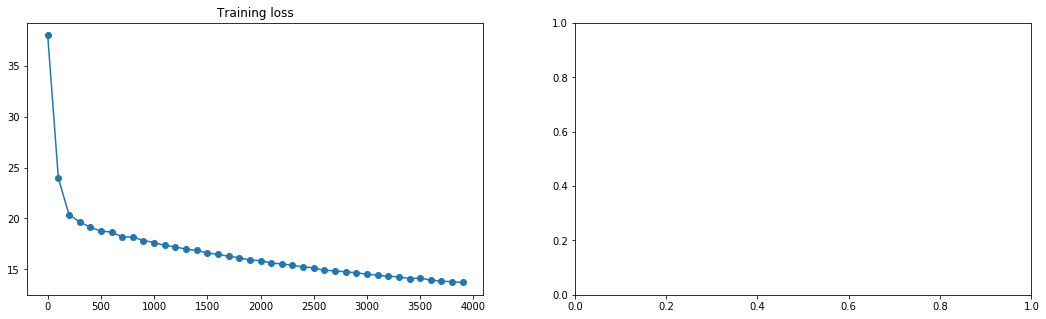

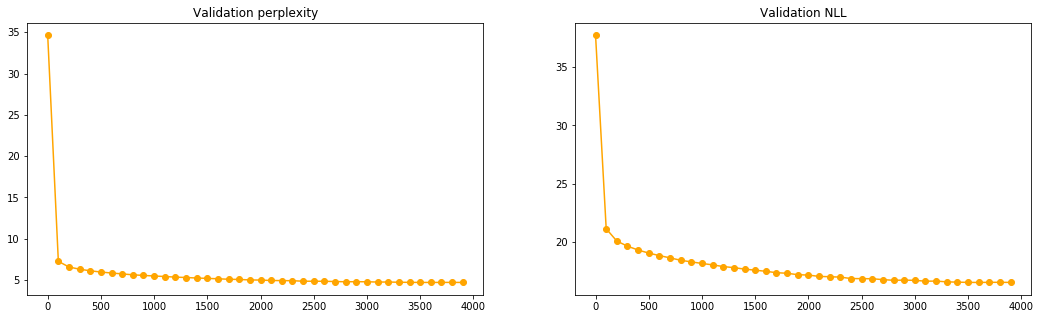

In [35]:
steps, training_NLL = list(zip(*train_NLLs))
_, val_ppl = list(zip(*val_perplexities))
_, val_NLL = list(zip(*val_NLLs))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Plot training loss
ax1.set_title("Training loss")
ax1.plot(steps, training_NLL, "-o")
plt.show()

# Plot validation perplexities.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.set_title("Validation perplexity")
ax1.plot(steps, val_ppl, "-o", color="orange")
ax2.set_title("Validation NLL")
ax2.plot(steps, val_NLL, "-o",  color="orange")
plt.show()
print()

Let's load the best model according to validation perplexity and compute its perplexity on the test data:

In [36]:
# Load the best model from disk.
model = CharLM(
    vocab_size=vocab.size(), 
    emb_size=emb_size, 
    hidden_size=hidden_size,     
    pad_idx=vocab[PAD_TOKEN],
    dropout=dropout)
model.load_state_dict(torch.load(best_model))
model = model.to(device)

# Compute test perplexity and ELBO.
test_perplexity, test_NLL = eval_perplexity(model, test_dataset, vocab, device)
print("test perplexity = %.2f -- test NLL = %.2f" % 
      (test_perplexity, test_NLL))

test perplexity = 4.78 -- test NLL = 16.66


# Qualitative analysis

Let's generate some wordforms from our model and inspect what our model assigns non-negligible probability mass to.

In [37]:
# Generate 10 samples from the standard normal prior.
num_samples = 10

samples = ancestral_sampling(model, vocab, batch_size=num_samples, device=device)
for sample in batch_to_words(samples, vocab):        
    print("-- Model generation: \"%s\"" % sample)

-- Model generation: "disparará"
-- Model generation: "pasquemas"
-- Model generation: "rechate"
-- Model generation: "survendiano"
-- Model generation: "causa"
-- Model generation: "exclamare"
-- Model generation: "anestaciones"
-- Model generation: "clavaremos"
-- Model generation: "cautellearon"
-- Model generation: "decelémica"
